### Reconstruction errors

This notebook shows how numerical errors propagate through the invertible architectures 
by showing the evolution of the SNR through the model layers

In [1]:
import numpy as np
import torch
from torch import nn
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from helpers import *
from rec_error_helpers import log_rec, summarize_errors, init_data
from models import IFlatXD, IResXD

/home/tristan/anaconda3/envs/torch4/lib/python3.7/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


In [2]:
device = 1
batch_size = 256

dataset = cifar10(root='./data/cifar10')
train_set = list(zip(transpose(normalise(pad(dataset['train']['data'], 4))), dataset['train']['labels']))
transforms = [Crop(32, 32), FlipLR(), Cutout(8, 8)]
train_batches = Batches(Transform(train_set, transforms), batch_size, shuffle=True, 
                        set_random_choices=True, drop_last=True, device=device)
batch  = next(iter(train_batches))

Files already downloaded and verified
Files already downloaded and verified


In [3]:
invert = True
skip_invert = True
invert = True
negative_slope = 0.2
ieps = 0.0001
nlayers=[2, 3, 3]
infeatures = 32
pools = ["channel", "channel"]

# SNR through layers

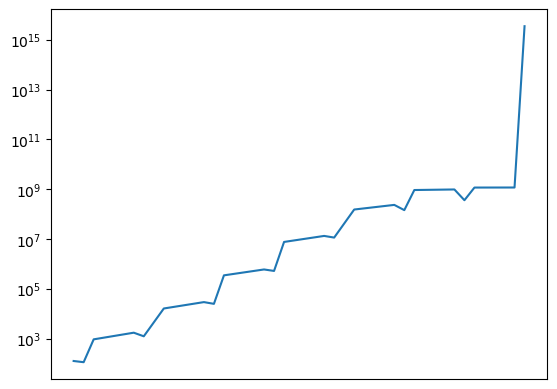

In [10]:
# Data 
inp    = batch["input"].clone()
target = batch["target"].clone()

# Model
model = IFlatXD(infeatures=infeatures, invert=invert, layers=nlayers, pools=pools,
                negative_slope=negative_slope, bn_ieps=ieps, inchannels=3).cuda(device)
handles, data=log_rec(model)

# Run fwd + bwd
output = model(inp)
output.sum().backward()

# Process and plot
df = summarize_errors(data)
init_data(data)

plt.style.use("default")
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

df1 = df[df.layer.isin(["IConv2dXD", "IBatchNorm3d", "ILeakyReLU"])]
ax=df1["snr"].plot(logy=True)
ax.figure.savefig("figures/Error propagation flat")

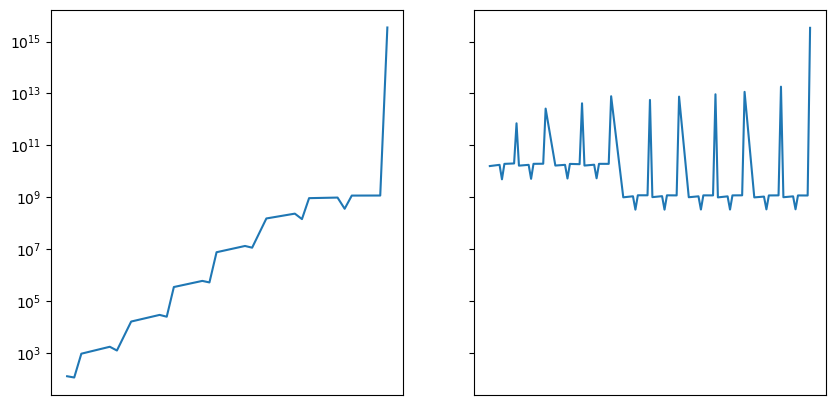

In [23]:
fig, ax = plt.subplots(1,2, figsize=(10,5), sharey=True)
plt.style.use("default")

ax[0].tick_params(
    axis='x',        
    which='both',    
    bottom=False,     
    top=False,         
    labelbottom=False) 

ax[1].tick_params(
    axis='x',        
    which='both',    
    bottom=False,     
    top=False,         
    labelbottom=False) 

df1["snr"].plot(logy=True, ax=ax[0])
df2["snr"].iloc[9:].plot(logy=True, ax=ax[1])

fig.savefig("figures/Error propagation residual")

In [15]:
df2

,Id,layer,bwd_cnt,snr
1,1,IConv2dXD,1,inf
3,3,IBatchNorm3d,1,10705435648.0
4,4,ILeakyReLU,1,10679172096.0
8,8,IConv2dXD,1,114619621376.0
12,12,IBatchNorm3d,1,131419054080.0
...,...,...,...,...
149,149,IBatchNorm3d,1,1092363136.0
150,150,ILeakyReLU,1,346250528.0
151,151,IConv2dXD,1,1184569344.0
155,155,IBatchNorm3d,1,1179111552.0
